### **Deep Learning Group Project 23-24**

##### **Group 5**

**Elements**:
- Frederico Portela | R20181072 | r20181072@novaims.unl.pt
- ...
- ...
- ...
- ...


**In this notebook:**
1. ... *describe main objectives of the notebook*
2. ...
3. ...


**Index**
1. Data Imports <>
2. ... <>

In [1]:
# *********************************
# Library Imports
# *********************************

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # trying to mute tf's warnings (not working)
import pickle
import shutil
import itertools
from typing import Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import tensorflow as tf
import tensorflow.keras.backend as K # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Rescaling, Dense, MaxPooling2D, Conv2D, Flatten, Dropout # type: ignore
from tensorflow.keras.utils import image_dataset_from_directory # type: ignore
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, TensorBoard, # type: ignore
                                        ReduceLROnPlateau, LearningRateScheduler)
from tensorflow.keras.metrics import F1Score, Precision, Recall, Accuracy # type: ignore
from tensorflow.keras import regularizers  # type: ignore
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.optimizers import Adam, RMSprop # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# sometimes with notebooks updates
# are not successfully imported
# we need to 'manually' reload the
# module
from importlib import reload
import utils.constants
import utils.visuals
import utils.gradcam
reload(utils.constants)
reload(utils.visuals)
reload(utils.gradcam)
from utils.constants import (BATCH_SIZE, IMAGE_SIZE, INPUT_SHAPE,
                             CLASS_INT_TO_STR, MALIGN_DISEASES)
from utils.visuals import ModelVisualEvaluation
from utils.gradcam import GradCAM, read_image_to_array

In [2]:
# *********************************
# Importing data (resized)
# *********************************

train_path = os.path.join('data', 'train')
val_path = os.path.join('data', 'val')
test_path = os.path.join('data', 'test')

# with the exception of the directory arg all
# other args will be the same for each set
import_kwargs = {
    'labels': 'inferred',
    'label_mode': 'categorical',  # if 'categorical' use 'categorical_crossentropy', if 'int' use 'sparse_categorical_crossentropy'
    'color_mode': 'rgb',
    'batch_size': BATCH_SIZE,
    'image_size': IMAGE_SIZE,
    'seed': None,
    'interpolation': 'bilinear',
    'crop_to_aspect_ratio': True
}

# this function returns a tf.data.Dataset object
train_data = image_dataset_from_directory(
    train_path,
    shuffle=True,
    **import_kwargs
)

val_data = image_dataset_from_directory(
    val_path,
    shuffle=False,
    **import_kwargs
)

test_data = image_dataset_from_directory(
    test_path,
    shuffle=False,
    **import_kwargs
)

# making sure all partitions have the same labels in the same order
assert train_data.class_names == val_data.class_names == test_data.class_names

# NOTE reading data to memory does not work, I get an error: MemoryError:
# Unable to allocate 2.12 GiB for an array with shape (11556, 128, 128, 3) and data type float32

Found 11556 files belonging to 114 classes.
Found 2477 files belonging to 114 classes.
Found 2477 files belonging to 114 classes.


In [3]:
# # ******************************************
# # Concatenating image with numeric data
# # ******************************************

# # the idea here is to extend the image datasets
# # with numeric data (e.g. fitzpatrick scale)

# CSV_PATH = os.path.join('data', 'fitzpatrick17k.csv')

# def get_numeric_data(data: tf.data.Dataset) -> pd.DataFrame:
#     """
#     From the imported image datasets we can access
#     the path of the files. The way we stored the images,
#     i.e. the img name is the hash of the row where that
#     img exists in the original file, allows us to map each
#     image to the corresponding numeric data.
#     """
#     # extracting filenames
#     filenames = []
#     for path in data.file_paths:
#         filenames.append(os.path.basename(path))
    
#     # removing .jpg string
#     filenames = list(map(lambda x: x[:-4], filenames))
    
#     # accessing the original csv file with the num. data
#     num_data = []
#     og_df = pd.read_csv(CSV_PATH)
#     for img in filenames:
#         row_values = og_df.loc[og_df['md5hash'] == img, ['fitzpatrick_scale', 'fitzpatrick_centaur']].values.tolist()[0]
#         num_data.append(row_values)
    
#     # num_data is a list of lists and for easier
#     # manipulation we should change it to a pd df
#     num_data = pd.DataFrame(num_data, columns=['fitz_1', 'fitz_2'])
    
#     # there are pseudo-missing values (i.e. -1) that
#     # we'll replace with the average
#     num_data = num_data.replace(-1, np.nan)
#     means = np.nanmean(num_data, axis=0)
#     num_data['fitz_1'] = num_data['fitz_1'].fillna(means[0])
#     num_data['fitz_2'] = num_data['fitz_2'].fillna(means[1])
    
#     return num_data

# train_data_num = get_numeric_data(train_data)
# val_data_num = get_numeric_data(val_data)
# test_data_num = get_numeric_data(test_data)   

# # OPTIONAL   
# # NNs in general prefer its data to take on values
# # on smaller intervals, e.g. [0, 1]
# scaler = MinMaxScaler()
# train_data_num = pd.DataFrame(scaler.fit_transform(train_data_num), columns=['fitz_1', 'fitz_2'])  # fitting to train
# val_data_num = pd.DataFrame(scaler.transform(val_data_num), columns=['fitz_1', 'fitz_2']) # transforming the others
# test_data_num = pd.DataFrame(scaler.transform(test_data_num), columns=['fitz_1', 'fitz_2'])

# def concatenate_img_and_num_data(img_data: tf.data.Dataset,
#                                  num_data: pd.DataFrame) -> tf.data.Dataset:
    
#     def combine_batch(batch1, batch2):
#         (img_batch, num_batch) = batch1, batch2
#         return (
#             (img_batch[0], num_batch),
#             img_batch[1]
#         )
    
#     # turning numeric data into a tf.dataset
#     num_data = tf.data.Dataset.from_tensor_slices(num_data).batch(BATCH_SIZE)
    
#     # zipping the datasets
#     combined_data = tf.data.Dataset.zip((img_data, num_data))
    
#     # restructuring the dataset into ((image_data, num_data), labels)
#     combined_data = combined_data.map(combine_batch)
    
#     return combined_data

# train_data = concatenate_img_and_num_data(train_data, train_data_num)
# val_data = concatenate_img_and_num_data(val_data, val_data_num)
# test_data = concatenate_img_and_num_data(test_data, test_data_num)

In [3]:
# *********************************
# Defining class weigths
# *********************************

# our dataset shows heavy data imbalance, a first-line measure to combat
# its consequences is to set class weights, i.e. for underrepresented
# classes our model's loss will increase by a factor larger than 1 if
# the expected class is different from the real class, and will increase
# by a factor smaller than 1 for over represented classes

def get_balanced_class_weights(data: tf.data.Dataset) -> dict:
    """
    How do we know the dict is ordered accordingly?
    The data comes from the image_dataset_from_directory method
    which sorts the classes by alphabetical order and replaces
    them by their index, e.g. acne is 2nd, and in this function
    we use the np.unique method that sorts the classes by ascending
    order, i.e. starts at 0 and ends at 113.
    
    Args:
        data: dataset
        
    Returns:
        dict: key, value: class, weight
    """
    y = []
    iterdata = iter(data)
    for batch in iterdata:
        y += [np.argmax(i) for i in batch[-1]]

    class_weights = compute_class_weight('balanced',
                                         classes=np.unique(y),
                                         y=y)
    dict_weights = dict(
        zip(range(len(class_weights)), class_weights)
    )
    return dict_weights

In [4]:
# *********************************
# Defining Callbacks
# *********************************

# how to implement custom metric for early stopping callback:
# similar implementation of callback that we want: https://datascience.stackexchange.com/questions/26833/is-there-away-to-change-the-metric-used-by-the-early-stopping-callback-in-keras
# data generator and validation data error: https://stackoverflow.com/questions/61939790/keras-custom-metrics-self-validation-data-is-none-when-using-data-generators
# how to write custom callbacks: https://keras.io/guides/writing_your_own_callbacks/

# NOTES:
# - EarlyStopping: stops early if target metric not increasing
# - ModelCheckpoint: saves model
# - TensorBoard: to visually assess our model's traning
# - ReduceLROnPlateau: reduces LR dynamically

# TODO:
# - check learning rate scheduler: https://keras.io/api/callbacks/learning_rate_scheduler/

class F1History(tf.keras.callbacks.Callback):
    """
    how to: https://stackoverflow.com/questions/52285501/how-can-i-create-a-custom-callback-in-keras
    The idea here is to compute and log the macro averaged f1 score
    so that we can monitor it during training. And if needed use it
    to monitor other callbacks, such as early stopping.
    """
    def __init__(self, validation_data: tf.data.Dataset):
        super().__init__()
        self.validation_data = validation_data  # is a generator
        self.f1_scores = []
        
    def on_epoch_end(self, epoch, logs={}):
        y_true, y_pred = [], []
        for batch_X, batch_y in self.validation_data:
            y_true += np.argmax(batch_y, axis=1).tolist()
            y_pred += np.argmax(self.model.predict(batch_X, verbose=0), axis=1).tolist()
        
        f1 = f1_score(y_true, y_pred, average='macro')
        self.f1_scores.append(f1)
        logs['F1_score_val'] = f1


def get_callback_list(model_path: str,
                      *other_callbacks,
                      monitor:str = 'val_loss',
                      early_stop_patience: int = 1) -> list:
    """
    Returns a pre-specified, fixed, callback list
    plus any other custom callbacks added as non-keyword
    arguments.
    
    Args:
        model_path: ModelCheckpoint callback stores model
        to path.
        monitor: Metric to monitor. By default it's 'val_loss'.
        other_callbacks: Other callbacks to include.
    
    Returns:
        List of callbacks.
    """
    
    if other_callbacks:
        other_callbacks = list(other_callbacks)
    else:
        other_callbacks = []
        
    callbacks_list = [
        
        EarlyStopping(monitor=monitor,
                      patience=early_stop_patience),
        
        ModelCheckpoint(filepath=model_path,
                        monitor=monitor,
                        save_best_only=True),
        
        TensorBoard(log_dir='log_dir',
                    histogram_freq=1),
        
        ReduceLROnPlateau(monitor=monitor,
                          factor=0.1,
                          patience=5,
                          min_lr=1e-30,
                          cooldown=3,
                          verbose=0)
        
    ]

    # NOTE the order matters, the custom callback should be the first
    # in the list otherwise its logs will not be updated between epochs
    # and the other callbacks will not have be able to monitor the custom
    # metric
    return other_callbacks + callbacks_list

In [5]:
# *********************************
# Saving and loading models
# *********************************

# in case we want to save history to plot loss or
# another metric later on. we can store it as a pickle file
# sending to file

def save_model_history(history, model_name):
    with open(os.path.join('model_dir', 'history', model_name), 'wb') as history_pickle:
        pickle.dump(history, history_pickle)

def load_model_history(model_name):
    with open(os.path.join('model_dir', 'history', model_name), 'rb') as history_pickle:
        history = pickle.load(history_pickle)
    return history

In [7]:
# *********************************
# Creating baseline model
# *********************************

def build_basemodel(*, augmentation_pipeline: tf.keras.Model = None) -> tf.keras.Model:
    # building
    inputs = tf.keras.Input(shape=INPUT_SHAPE, name='input_layer')
    
    if augmentation_pipeline:
        x = augmentation_pipeline(inputs)
    else:
        x = inputs
    
    x = tf.keras.layers.Rescaling(scale=1/255.0, name='rescaling_layer')(x)

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', name='first_conv_layer')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='first_pool_layer')(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='second_conv_layer')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='second_pool_layer')(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='last_conv_layer')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='last_pool_layer')(x)

    x = tf.keras.layers.Flatten(name='flatten_layer')(x)
    x = tf.keras.layers.Dense(256, activation='relu', name='first_dense_layer')(x)
    outputs = tf.keras.layers.Dense(114, activation='softmax', name='output_layer')(x)

    model = tf.keras.Model(
        inputs=inputs,
        outputs=outputs,
        name='baseline-model'
    )
    
    return model

In [17]:
# *********************************
# Building baseline model
# *********************************

# NOTE:
# - F1Score class only works if we import labels as 'categorical' and use 'categorical_crossentropy'
#   if we import our data as 'int' and therefore use 'sparse_categorical_crossentropy' we will get
#   an error (for that matter, all tf.keras.metrics seem to return the same error).
#   error: ValueError: Shapes (None, 114) and (None, 1) are incompatible or
#   ValueError: Tensor conversion requested dtype float32 for Tensor with dtype int32:
#   <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=int32>
#   the latter appears if we use F1Score whereas the former if we use Precision or Recall

basemodel = build_basemodel()

# understanding # of params:
# 1st conv. layer: 32 filters of dims. (3, 3, 3), 3 height, 3 width, 3 channels (rgb) => 32*3*3*3 + 32 (bias) = 896
# 1st max pool. layer: reduces size of filter map by 2 (because shape is (2, 2)) to 63 by 63 (not 64 due to stride of filters)
# 2nd conv. layer: 64 filters of dims. (3, 3, 32), same filter size but now each filter stack is composed of 32 indiv. filters => 64*3*3*32 + 64 = 18,496
# 2nd. max pool. layer: once again reduces size of filter map by factor of 2 to 30 by 30 (depends on the stride selected)
# Flatten layer: each filter map (2D matrix) is turned into a 1d array: 64 filters * 30 height * 30 width = 57,600
# 1st dense layer: each of the 'neurons' on the flatten layer are mapped to each of 256 of the neurons in this layer = 57,000 * 256 + 256 (bias terms) = 14,745,856
# 2nd dense layer: same rationale as above (common vanilla NN), 256*114 + 114 = 29,298
# basemodel.summary()

# compiling
metrics = [
    F1Score(average='macro'),
    Precision(),
    Recall(),
    Accuracy()
]

basemodel_compile_kwargs = {
    'optimizer': Adam(learning_rate=0.001),  # default is 0.001
    'loss': 'categorical_crossentropy',
    'metrics': metrics
}

basemodel.compile(**basemodel_compile_kwargs)

# build optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# optimizer.build(basemodel.trainable_variables)

# fitting
model_name = 'baseline-model'
history = basemodel.fit(train_data,
                        epochs=30,
                        validation_data=val_data,
                        class_weight=get_balanced_class_weights(train_data),
                        callbacks=get_callback_list(
                            os.path.join('model_dir', 'models', f'{model_name}.h5'),
                            # F1History(val_data),
                            monitor='val_loss',  # actually 'val_f1_score' is not throwing an error, maybe F1History is not needed
                            early_stop_patience=3
                        ),
                        verbose=1)

save_model_history(history.history, f'{model_name}.pkl')

Epoch 1/30
  1/362 [..............................] - ETA: 18:41:07 - loss: 4.4798 - f1_score: 0.0000e+00 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - accuracy: 0.0000e+00

In [8]:
from tensorflow.keras.utils import plot_model # type: ignore
# for issues see: https://stackoverflow.com/questions/47188756/keras-plot-model-tells-me-to-install-pydot/47209738#47209738
plot_model(basemodel, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [81]:
# *********************************
# Tensorboard
# *********************************

# run:
!tensorboard --logdir=log_dir
# go to: http://localhost:6006/
# 'interrupt' this cell once you are done

# or uncomment and click on link (you'll need to have vscode's extension installed):
# %load_ext tensorboard
# %tensorboard --logdir 'C:\Users\fmppo\Desktop\MSDSAA\Y1\S2\Deep Learning\Group Project\log_dir'

^C


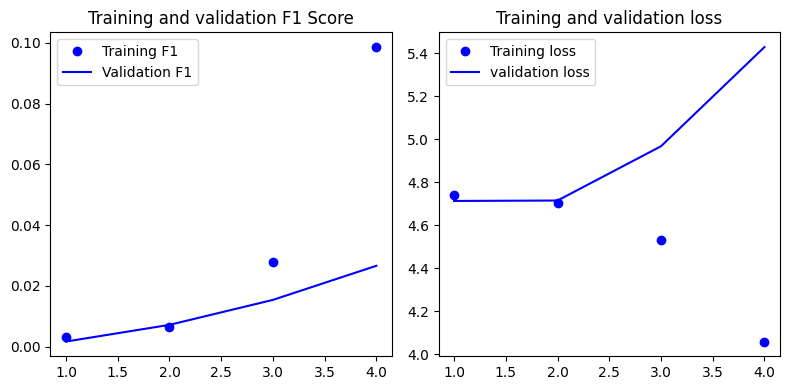

In [10]:
# *********************************
# Plotting train vs. val scores
# *********************************

# TODO: make this into a function with added dynamics,
# i.e. able to plot in a grid instead of a pair other
# stuff like recall and precision

ModelVisualEvaluation.plot_history_f1(history.history)

78/78 [==============================] - 6s 64ms/step


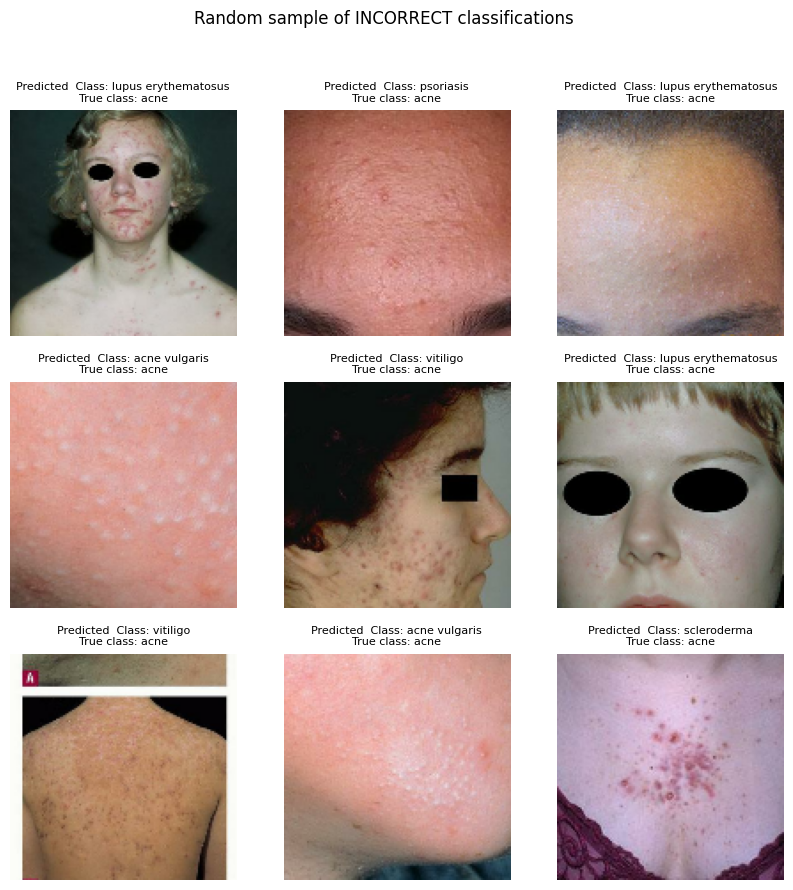

In [163]:
# **********************************
# Sample of prediction results
# **********************************

# the idea here is to show a sample of the
# images that our model got wrong (or right)
# to quickly and roughly assess the model's
# prediction quality

X_val = np.array([x for batch_x, _ in val_data for x in batch_x])
y_val_true = np.array([np.argmax(y) for _, batch_y in val_data for y in batch_y])
y_val_pred = np.argmax(basemodel.predict(X_val), axis=1)

ModelVisualEvaluation.plot_prediction_sample(X_val, y_val_true,
                                             y_val_pred, show_class=1,
                                             only_show_wrong=True)

# TODO: at least for acne it might be useful to have a model that would enhance different colors

In [168]:
# **********************************
# Benign vs. malign classification
# **********************************

# our main objective is to predict a class on a set of 114
# possible classes. Nonetheless, we believe that we also can
# and should assess our model's performance, as first-line metric,
# based on whether is it predicting correctly if the skin disease
# presented is benign or malign.

def convert_to_binary_classification_mode(y_true: np.ndarray, y_pred: np.ndarray,
                                          malign_disease_map: dict = MALIGN_DISEASES) -> tuple[np.ndarray]:
    """
    Converts the multi-class classification into a binary classification
    mode. The idea is to map all the classes that are malign into a single
    class and all the others into another class.
    
    Args:
        y_true: true labels
        y_pred: predicted labels
        malign_disease_map: dict mapping malign diseases to their respective class
        
    Returns:
        tuple: y_true_bin, y_pred_bin
    """
    mapper = lambda arr: [malign_disease_map[i] for i in arr]
    y_true_bin = mapper(y_true)
    y_pred_bin = mapper(y_pred)
    return (y_true_bin, y_pred_bin)


# from the previous cell we already have y val, pred and true
y_val_bin_true, y_val_bin_pred = convert_to_binary_classification_mode(y_val_true, y_val_pred)

# quality assessment
print('Classification Report:')
print(classification_report(y_val_bin_true, y_val_bin_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      2138
           1       0.27      0.35      0.31       339

    accuracy                           0.78      2477
   macro avg       0.58      0.60      0.59      2477
weighted avg       0.81      0.78      0.79      2477



In [37]:
# *********************************
# Data Augmentation
# *********************************

# what if we try out the same architecture used in the
# baseline model but this time with data augmentation
# instead of class weights.

# useful links:
# - how to: https://machinelearningmastery.com/image-augmentation-deep-learning-keras/
# - only specific classes: https://stackoverflow.com/questions/72378806/augmentation-layers-only-for-specific-classes
# - same as above: https://stackoverflow.com/questions/66986830/image-augmentation-with-tensorflow-so-all-classes-have-exact-same-number-of-imag
# - https://stackoverflow.com/questions/49836816/tensorflow-cnn-image-augmentation-pipeline?rq=3

In [12]:
# our first approch, the simplest one, is to oversample
# the minority classes so that all classes have the same
# amount of instances. NOTE that this is only applied to
# the train dataset and NOTE this cell is only run once

# copying the original train data to a new dir
# oversample_train_path = os.path.join('data', 'train-oversampled')
# shutil.copytree(train_path, oversample_train_path)

# which classes need to be oversample
# class_sizes = {}
# max_ = 0
# for dirname in os.listdir(train_path):
#     n = len(os.listdir(os.path.join('data', 'train', dirname)))
#     class_sizes[dirname] = n
#     if n > max_:
#         max_ = n

# oversampling
# def oversample_class(class_folder_path: str, new_n: int):
#     choices = np.random.choice(os.listdir(class_folder_path),
#                                new_n, replace=True)
#     chosen = {}
#     for choice in choices:
#         if choice in chosen.keys():
#             # for some classes the same instance will be chosen
#             # more than once. to oversample the image more than
#             # once we need to give it a new name
#             chosen[choice] += 1
#         else:
#             chosen[choice] = 1
        
#         dst = os.path.join(class_folder_path, f'{chosen[choice]}_{choice}.jpg')
#         shutil.copy(os.path.join(class_folder_path, choice), dst)

# for class_name, n_samples in class_sizes.items():
#     new_n = max_ - n_samples
#     if new_n:
#         oversample_class(os.path.join('data', 'train-oversampled', class_name), new_n)

'data\\train-oversampled'

In [9]:
# oversampled train: random copies of images of minority classes
train_data_oversampled = image_dataset_from_directory(
    os.path.join('data', 'train-oversampled'),
    shuffle=True,
    **import_kwargs
)

# augmented train: augmented data, class imbalance remains the same
# for now we are just importing the usual train data but afterwards
# we'll pass the data through a pipeline of augmentation layers
train_data_augmented = image_dataset_from_directory(
    train_path,
    shuffle=True,
    **import_kwargs
)

# using a mix of both oversampled and augmented data
# we'll import the oversampled dataset and then apply
# the augmentation pipeline
train_data_mixed = image_dataset_from_directory(
    os.path.join('data', 'train-oversampled'),
    shuffle=True,
    **import_kwargs
)

Found 52098 files belonging to 114 classes.
Found 11556 files belonging to 114 classes.
Found 52098 files belonging to 114 classes.


In [10]:
# *********************************
# Augmentation pipeline
# *********************************

# using imageDataGenerator to augment the data
# was returning obscure errors so we'll go with
# creating a augmentation pipeline which works
# the same way and is more explicit

augmentation_pipeline = Sequential([
    tf.keras.layers.RandomFlip(mode='horizontal', seed=42),
    tf.keras.layers.RandomRotation(factor=0.15, seed=42),
    tf.keras.layers.RandomZoom(height_factor=0.15, width_factor=0.15, seed=42),
    tf.keras.layers.RandomContrast(factor=0.15, seed=42),
    tf.keras.layers.RandomTranslation(height_factor=0.15, width_factor=0.15, seed=42)
], name='augmentation_pipeline')

In [ ]:
# *****************************
# Fitting oversampled model
# *****************************
# the idea here and in the cell below is to compare the
# performance of the # baseline model with the augmented
# data and the oversampled data

oversampled_model = build_basemodel()
optimizer = Adam(learning_rate=0.001)  # it seems optimizers keep state, so we need to re-instantiate them between fits
basemodel_compile_kwargs['optimizer'] = optimizer
oversampled_model.compile(**basemodel_compile_kwargs)
oversampled_model_name = 'oversampled-base-model'
oversampled_history = oversampled_model.fit(train_data_oversampled,
                                            epochs=30,
                                            validation_data=val_data,
                                            callbacks=get_callback_list(
                                                os.path.join('model_dir', 'models', f'{oversampled_model_name}.h5'),
                                                # F1History(val_data),
                                                monitor='val_loss',
                                                early_stop_patience=3),
                                            verbose=1)

save_model_history(oversampled_history.history, f'{oversampled_model_name}.pkl')

Epoch 1/30
1629/1629 [==============================] - ETA: 0s - loss: 3.1175 - f1_score: 0.3485 - precision: 0.8164 - recall: 0.2328 - accuracy: 5.3668e-04

c:\Users\fmppo\Desktop\MSDSAA\Y1\S2\Deep Learning\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1629/1629 [==============================] - 598s 364ms/step - loss: 3.1175 - f1_score: 0.3485 - precision: 0.8164 - recall: 0.2328 - accuracy: 5.3668e-04 - val_loss: 5.9598 - val_f1_score: 0.0871 - val_precision: 0.1669 - val_recall: 0.0432 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/30
1629/1629 [==============================] - 607s 372ms/step - loss: 0.6125 - f1_score: 0.8600 - precision: 0.9597 - recall: 0.8130 - accuracy: 0.0027 - val_loss: 8.9866 - val_f1_score: 0.0826 - val_precision: 0.1254 - val_recall: 0.0654 - val_accuracy: 2.0186e-04 - lr: 0.0010
Epoch 3/30
1629/1629 [==============================] - 601s 368ms/step - loss: 0.2008 - f1_score: 0.9508 - precision: 0.9755 - recall: 0.9359 - accuracy: 0.0186 - val_loss: 12.2551 - val_f1_score: 0.0823 - val_precision: 0.1086 - val_recall: 0.0763 - val_accuracy: 0.0032 - lr: 0.0010
Epoch 4/30
1629/1629 [==============================] - 687s 421ms/step - loss: 0.1314 - f1_score: 0.9676 - precision: 0.9785 - recall: 0.9588 

In [20]:
# *****************************
# Fitting augmented model
# *****************************

augmented_model = build_basemodel(augmentation_pipeline=augmentation_pipeline)
optimizer = Adam(learning_rate=0.001)  # it seems optimizers keep state, so we need to re-instantiate them between fits
basemodel_compile_kwargs['optimizer'] = optimizer
augmented_model.compile(**basemodel_compile_kwargs)
augmented_model_name = 'augmented-base-model'
augmented_history = augmented_model.fit(train_data_augmented,
                                        epochs=30,
                                        validation_data=val_data,
                                        callbacks=get_callback_list(
                                            os.path.join('model_dir', 'models', f'{augmented_model_name}.h5'),
                                            # F1History(val_data),
                                            monitor='val_loss',
                                            early_stop_patience=3),
                                        verbose=1)

save_model_history(augmented_history.history, f'{augmented_model_name}.pkl')

Epoch 1/30
362/362 [==============================] - 149s 404ms/step - loss: 4.5385 - f1_score: 0.0244 - precision: 0.1065 - recall: 0.0140 - accuracy: 8.0637e-04 - val_loss: 4.4962 - val_f1_score: 0.0014 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/30
362/362 [==============================] - 154s 424ms/step - loss: 4.4786 - f1_score: 0.0040 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 4.4160 - val_f1_score: 0.0049 - val_precision: 1.0000 - val_recall: 4.0371e-04 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/30
362/362 [==============================] - 154s 424ms/step - loss: 4.3990 - f1_score: 0.0084 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 4.3563 - val_f1_score: 0.0117 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/30
362/362 [==============================] - 154s 424ms/step - loss: 4.3220 - f1_s

In [63]:
# *****************************
# Fitting augmented model
# *****************************

mixed_model = build_basemodel(augmentation_pipeline=augmentation_pipeline)
optimizer = Adam(learning_rate=0.001)  # it seems optimizers keep state, so we need to re-instantiate them between fits
basemodel_compile_kwargs['optimizer'] = optimizer
mixed_model.compile(**basemodel_compile_kwargs)
mixed_model_name = 'mixed-base-model'
mixed_history = mixed_model.fit(train_data_mixed,
                                epochs=30,
                                validation_data=val_data,
                                callbacks=get_callback_list(
                                    os.path.join('model_dir', 'models', f'{mixed_model_name}.h5'),
                                    # F1History(val_data),
                                    monitor='val_loss',
                                    early_stop_patience=3),
                                verbose=1)

save_model_history(mixed_history.history, f'{mixed_model_name}.pkl')

Epoch 1/30
1629/1629 [==============================] - ETA: 0s - loss: 4.6257 - f1_score: 0.0256 - precision: 0.4020 - recall: 0.0015 - accuracy: 0.0000e+00

c:\Users\fmppo\Desktop\MSDSAA\Y1\S2\Deep Learning\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1629/1629 [==============================] - 926s 567ms/step - loss: 4.6257 - f1_score: 0.0256 - precision: 0.4020 - recall: 0.0015 - accuracy: 0.0000e+00 - val_loss: 4.5752 - val_f1_score: 0.0266 - val_precision: 0.3333 - val_recall: 4.0371e-04 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/30
1629/1629 [==============================] - 900s 552ms/step - loss: 4.2594 - f1_score: 0.0607 - precision: 0.5975 - recall: 0.0037 - accuracy: 0.0000e+00 - val_loss: 4.3858 - val_f1_score: 0.0464 - val_precision: 0.4333 - val_recall: 0.0052 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/30
1629/1629 [==============================] - 909s 558ms/step - loss: 3.9094 - f1_score: 0.1146 - precision: 0.6659 - recall: 0.0160 - accuracy: 0.0000e+00 - val_loss: 4.3813 - val_f1_score: 0.0610 - val_precision: 0.3143 - val_recall: 0.0089 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/30
1629/1629 [==============================] - 835s 512ms/step - loss: 3.6085 - f1_score: 0.1657 - precision: 0.6972 - 

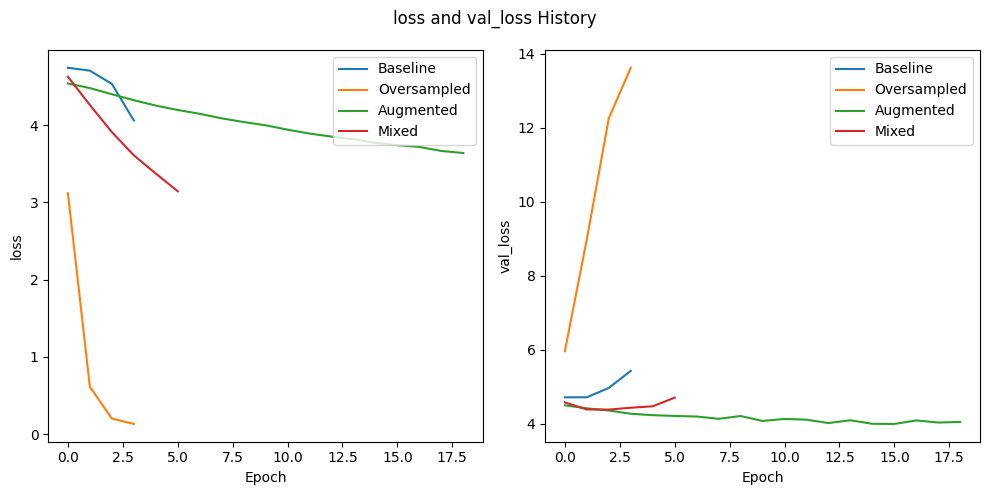

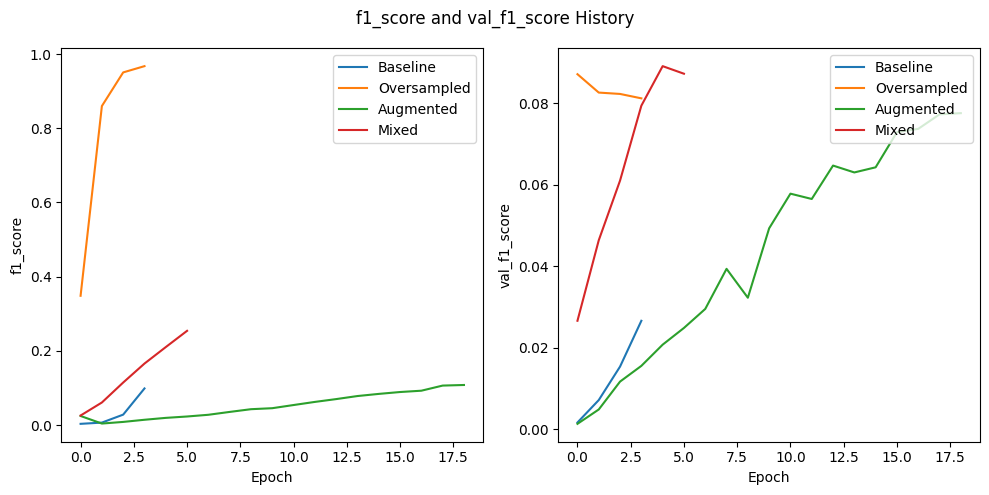

In [65]:
# *****************************
# Comparing models
# *****************************

def compare_models(histories: Union[dict, list[dict]],
                   *,
                   names: Union[str, list[str]] = 'Model',
                   metrics: Union[list[tuple], tuple] = ('loss', 'val_loss')):
    """
    Plots the training and validation history of one or more models.

    Args:
        histories: A dictionary or a list of dictionaries containing the training and validation
            history of the models. Each dictionary should have the metrics as keys and the corresponding values as lists.
        names: The names of the models. It can be a single string or a list of strings.
            Defaults to 'Model'.
        metrics: The metrics to plot. It can be a single tuple or a list of tuples.
            Each tuple should contain two strings representing the training metric and the validation metric.
            Defaults to ('loss', 'val_loss').

    Raises:
        ValueError: If no histories are provided or if the metrics argument is not a list or a tuple.
        ValueError: If the histories do not share the same metrics.

    Returns:
        None
    """
    if not histories:
        raise ValueError('No histories to plot.')

    if isinstance(histories, dict):
        histories = [histories]

    if isinstance(names, str):
        names = [names] * len(histories)

    if isinstance(metrics, tuple):
        metrics = [metrics]
    elif not isinstance(metrics, list):
        raise ValueError('metrics must be a list or a tuple.')

    # all histories must share the same metrics
    u_metrics = set([metric for pair in metrics for metric in pair])
    if not all(set(hist.keys()).issuperset(u_metrics) for hist in histories):
        raise ValueError('Histories must share the same metrics.')

    # for each metric pair (train, val) we want to plot, on the same plot
    # the history of each model for that pair of metrics
    for i, (train_metric, val_metric) in enumerate(metrics):
        
        # ax1 for train, ax2 for val
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle(f'{train_metric} and {val_metric} History')
        
        for j, history in enumerate(histories):
            ax1.plot(history[train_metric], label=f'{names[j]}')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel(train_metric)
            ax1.legend(loc="upper right")

        for k, history in enumerate(histories):
            ax2.plot(history[val_metric], label=f'{names[k]}')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel(val_metric)
            ax2.legend(loc="upper right")

        plt.tight_layout()
        plt.show()


compare_models([history.history, oversampled_history.history, augmented_history.history, mixed_history.history],
               names=['Baseline', 'Oversampled', 'Augmented', 'Mixed'],
               metrics=[('loss', 'val_loss'), ('f1_score', 'val_f1_score')])

In [ ]:
# *****************************
# Regularization
# *****************************

# all models seem to be overfitting, we'll try to
# regularize them by adding dropout layers and l2
# regularization

def build_regularized_basemodel(*, augmentation_pipeline: tf.keras.Model = None) -> tf.keras.Model:
    # building
    inputs = tf.keras.Input(shape=INPUT_SHAPE, name='input_layer')
    
    if augmentation_pipeline:
        x = augmentation_pipeline(inputs)
    else:
        x = inputs
    
    x = tf.keras.layers.Rescaling(scale=1/255.0, name='rescaling_layer')(x)

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', name='first_conv_layer')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='first_pool_layer')(x)
    x = tf.keras.layers.Dropout(0.2, name='first_dropout')(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='second_conv_layer')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='second_pool_layer')(x)
    x = tf.keras.layers.Dropout(0.2, name='second_dropout')(x)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='last_conv_layer')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='last_pool_layer')(x)
    x = tf.keras.layers.Dropout(0.2, name='last_dropout')(x)

    x = tf.keras.layers.Flatten(name='flatten_layer')(x)
    x = tf.keras.layers.Dense(256, activation='relu', name='first_dense_layer')(x)
    x = tf.keras.layers.Dropout(0.2, name='dense_dropout')(x)
    outputs = tf.keras.layers.Dense(114, activation='softmax', name='output_layer')(x)

    model = tf.keras.Model(
        inputs=inputs,
        outputs=outputs,
        name='baseline-model'
    )
    
    return model

In [ ]:
# TODO, although this is a possibly a dead end...

In [ ]:
# *****************************
# Transfer Learning
# *****************************

# the idea here is to use a pre-trained model
# for starters we'll use the VGG16 model as
# used in the paper that first showed the
# curated fitzpatrick17k dataset

# useful links:
# - paper: https://arxiv.org/abs/2104.09957
# - code: https://github.com/mattgroh/fitzpatrick17k

base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE
)

# freeze base model
base_model.trainable = False